<a href="https://colab.research.google.com/github/teamgaon/KIST/blob/main/220504_img_masking_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import albumentations
import albumentations.pytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
import albumentations as A
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime, timedelta
import random
import torchvision.transforms as transforms
import gc
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = glob('/content/drive/MyDrive/KIST/open/train/*/image/*')
images.sort()
metas  = glob('/content/drive/MyDrive/KIST/open/train/*/meta/*')
metas.sort()
labels = glob('/content/drive/MyDrive/KIST/open/train/*/label.csv')
labels.sort()

In [ ]:
label = pd.DataFrame()
for df in tqdm(labels):
  temp = pd.read_csv(df)
  label = pd.concat([label, temp], axis=0)

label = label.reset_index(drop=True)
label

100%|██████████| 75/75 [00:14<00:00,  5.10it/s]


In [ ]:
train = pd.DataFrame()
for df in tqdm(metas):
  temp = pd.DataFrame(pd.read_csv(df).mean().fillna(0)).T
  train = pd.concat([train, temp], axis=0)

train = train.reset_index(drop=True)
train

  0%|          | 0/1592 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 1592/1592 [00:24<00:00, 64.03it/s]


In [ ]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 50, 0])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

In [ ]:
area = []
for img in tqdm(images):
    image = cv2.imread(img)
    image_mask = create_mask_for_plant(image)
    per = len(np.where(image_mask>0)[0])/(len(image_mask)*len(image_mask[0]))
    area.append(per)

100%|██████████| 1592/1592 [34:11<00:00,  1.29s/it]


In [ ]:
train['area'] = area

In [ ]:
train.to_csv('/content/drive/MyDrive/KIST/train.csv', index=False)

In [39]:
train = pd.read_csv('/content/drive/MyDrive/KIST/train.csv')
train

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,area
0,22.236181,43.868542,77.740695,4.898172,487.226389,19.594792,0.000000,200.710166,201.000000,0.233721,17.417129,179.488256,18.854662,10.227934,145.968975,12.396976,21.122305,0.000000,0.097346
1,23.011319,44.573750,77.645972,4.687392,480.144444,20.855555,0.000000,200.856836,200.856836,0.233993,17.414777,179.413149,18.852110,13.706011,145.929643,12.389964,21.093542,0.000000,0.117491
2,22.931111,39.537708,77.514931,4.957483,489.068750,20.748611,0.000000,200.711621,200.423851,0.233993,17.417408,179.554817,18.854995,13.347289,146.041083,12.375941,21.137793,0.000000,0.138993
3,21.027986,58.497500,80.069930,4.006066,481.378472,18.195278,0.000000,200.133285,200.278936,0.233721,17.416580,179.504056,18.854097,7.522328,146.006121,12.370097,21.127837,0.000000,0.163337
4,21.874305,67.058819,81.349792,4.335634,490.568750,19.400486,0.000000,200.855804,201.000000,0.233721,17.417364,179.523273,18.854948,10.943099,145.999566,12.396976,21.126731,0.000000,0.188741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,25.165623,22.791783,80.082603,56.269708,491.783426,0.764425,115.480174,47.359769,7.496387,13.571429,23.507560,8.306292,22.507560,0.000000,180.053307,146.450415,12.427407,21.175485,0.397600
1588,25.352189,23.422029,79.727519,53.031480,520.282835,0.698547,117.884826,47.277056,7.494920,13.524673,23.499638,9.252668,22.499638,0.000000,179.435392,145.925273,12.391133,21.118987,0.401504
1589,25.109583,22.597986,79.028909,48.405139,577.442361,0.347149,113.178910,47.308518,7.483778,13.559653,23.500327,8.052391,22.500327,0.000000,179.423714,145.958049,12.366592,21.099073,0.406264
1590,24.915010,22.145587,80.112717,57.102988,503.247394,0.000000,118.029035,47.399856,7.467344,13.462600,23.498395,7.179364,22.498395,0.000000,179.362487,145.872513,12.385892,21.104083,0.404892


In [41]:
train['target'] = label['leaf_weight']
train

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,area,target
0,22.236181,43.868542,77.740695,4.898172,487.226389,19.594792,0.000000,200.710166,201.000000,0.233721,17.417129,179.488256,18.854662,10.227934,145.968975,12.396976,21.122305,0.000000,0.097346,49.193
1,23.011319,44.573750,77.645972,4.687392,480.144444,20.855555,0.000000,200.856836,200.856836,0.233993,17.414777,179.413149,18.852110,13.706011,145.929643,12.389964,21.093542,0.000000,0.117491,59.764
2,22.931111,39.537708,77.514931,4.957483,489.068750,20.748611,0.000000,200.711621,200.423851,0.233993,17.417408,179.554817,18.854995,13.347289,146.041083,12.375941,21.137793,0.000000,0.138993,72.209
3,21.027986,58.497500,80.069930,4.006066,481.378472,18.195278,0.000000,200.133285,200.278936,0.233721,17.416580,179.504056,18.854097,7.522328,146.006121,12.370097,21.127837,0.000000,0.163337,85.737
4,21.874305,67.058819,81.349792,4.335634,490.568750,19.400486,0.000000,200.855804,201.000000,0.233721,17.417364,179.523273,18.854948,10.943099,145.999566,12.396976,21.126731,0.000000,0.188741,102.537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,25.165623,22.791783,80.082603,56.269708,491.783426,0.764425,115.480174,47.359769,7.496387,13.571429,23.507560,8.306292,22.507560,0.000000,180.053307,146.450415,12.427407,21.175485,0.397600,211.497
1588,25.352189,23.422029,79.727519,53.031480,520.282835,0.698547,117.884826,47.277056,7.494920,13.524673,23.499638,9.252668,22.499638,0.000000,179.435392,145.925273,12.391133,21.118987,0.401504,214.116
1589,25.109583,22.597986,79.028909,48.405139,577.442361,0.347149,113.178910,47.308518,7.483778,13.559653,23.500327,8.052391,22.500327,0.000000,179.423714,145.958049,12.366592,21.099073,0.406264,214.293
1590,24.915010,22.145587,80.112717,57.102988,503.247394,0.000000,118.029035,47.399856,7.467344,13.462600,23.498395,7.179364,22.498395,0.000000,179.362487,145.872513,12.385892,21.104083,0.404892,210.872


In [48]:
X = train[train.columns[:-1]]
y = train['target']

In [49]:
X

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,area
0,22.236181,43.868542,77.740695,4.898172,487.226389,19.594792,0.000000,200.710166,201.000000,0.233721,17.417129,179.488256,18.854662,10.227934,145.968975,12.396976,21.122305,0.000000,0.097346
1,23.011319,44.573750,77.645972,4.687392,480.144444,20.855555,0.000000,200.856836,200.856836,0.233993,17.414777,179.413149,18.852110,13.706011,145.929643,12.389964,21.093542,0.000000,0.117491
2,22.931111,39.537708,77.514931,4.957483,489.068750,20.748611,0.000000,200.711621,200.423851,0.233993,17.417408,179.554817,18.854995,13.347289,146.041083,12.375941,21.137793,0.000000,0.138993
3,21.027986,58.497500,80.069930,4.006066,481.378472,18.195278,0.000000,200.133285,200.278936,0.233721,17.416580,179.504056,18.854097,7.522328,146.006121,12.370097,21.127837,0.000000,0.163337
4,21.874305,67.058819,81.349792,4.335634,490.568750,19.400486,0.000000,200.855804,201.000000,0.233721,17.417364,179.523273,18.854948,10.943099,145.999566,12.396976,21.126731,0.000000,0.188741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,25.165623,22.791783,80.082603,56.269708,491.783426,0.764425,115.480174,47.359769,7.496387,13.571429,23.507560,8.306292,22.507560,0.000000,180.053307,146.450415,12.427407,21.175485,0.397600
1588,25.352189,23.422029,79.727519,53.031480,520.282835,0.698547,117.884826,47.277056,7.494920,13.524673,23.499638,9.252668,22.499638,0.000000,179.435392,145.925273,12.391133,21.118987,0.401504
1589,25.109583,22.597986,79.028909,48.405139,577.442361,0.347149,113.178910,47.308518,7.483778,13.559653,23.500327,8.052391,22.500327,0.000000,179.423714,145.958049,12.366592,21.099073,0.406264
1590,24.915010,22.145587,80.112717,57.102988,503.247394,0.000000,118.029035,47.399856,7.467344,13.462600,23.498395,7.179364,22.498395,0.000000,179.362487,145.872513,12.385892,21.104083,0.404892


In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X

array([[0.63399485, 0.5731425 , 0.91664899, ..., 0.21150212, 0.        ,
        0.13528336],
       [0.6560955 , 0.58235604, 0.91553211, ..., 0.2112141 , 0.        ,
        0.16328014],
       [0.65380861, 0.51656016, 0.91398698, ..., 0.2116572 , 0.        ,
        0.19316208],
       ...,
       [0.7159209 , 0.29524269, 0.93183846, ..., 0.1238293 , 0.13468927,
        0.56459677],
       [0.71037327, 0.2893321 , 0.94461777, ..., 0.12402256, 0.13472124,
        0.56269013],
       [0.71276876, 0.29041771, 0.94166251, ..., 0.12379419, 0.13468927,
        0.56543557]])

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True)

In [54]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [57]:
y_pred = model.predict(X_test)

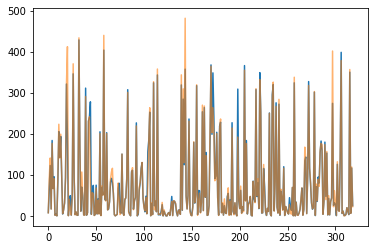

In [63]:
plt.plot(y_pred)
plt.plot(y_test.reset_index(drop=True), alpha=0.6)
plt.show()

In [64]:
model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

In [65]:
images = glob('/content/drive/MyDrive/KIST/open/test/image/*')
images.sort()
metas  = glob('/content/drive/MyDrive/KIST/open/test/meta/*')
metas.sort()

In [66]:
test = pd.DataFrame()
for df in tqdm(metas):
  temp = pd.DataFrame(pd.read_csv(df).mean().fillna(0)).T
  test = pd.concat([test, temp], axis=0)

test = test.reset_index(drop=True)
test

  0%|          | 0/460 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 460/460 [00:19<00:00, 24.07it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,23.634861,22.564583,69.500486,34.499792,400.265278,0.000000,6120.690250,47.377587,7.513205,13.499641,22.396963,6.194850,20.396963,0.000000,179.654483,146.104933,12.404568,21.144982
1,27.170347,28.738472,63.881805,50.837708,505.823611,0.000000,650.293681,33.581327,9.494891,4.720234,23.396068,23.871350,22.396068,0.000000,126.722885,103.602093,15.725275,7.395517
2,26.000278,25.541209,79.194857,65.933635,498.605976,1.778848,110.823069,47.220974,7.506396,13.524169,20.296656,42.891470,17.420928,0.609085,179.639881,146.111980,12.393446,21.134456
3,22.956944,22.361667,70.809792,45.377276,394.612500,0.592409,6324.772167,47.357602,7.500712,13.510350,22.395292,2.905725,20.395292,0.000000,179.414213,145.923088,12.387627,21.103499
4,23.016261,22.531736,73.886944,33.534167,418.561806,0.541303,6478.004611,47.139385,7.486061,13.446429,22.396376,3.182381,20.396376,0.000000,179.532497,146.036713,12.371266,21.124518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,26.715208,28.278403,59.644167,45.757778,483.540278,0.000000,757.208444,33.505503,9.448813,4.717489,23.394837,21.598959,22.394837,0.000000,126.669307,103.576911,15.707151,7.385245
456,23.941944,23.810417,69.238194,28.852708,393.603472,0.505359,735.014965,63.053914,52.313988,5.983643,22.396143,7.724439,20.396143,0.000000,288.376036,193.226108,85.842750,9.307178
457,23.692014,22.628750,80.644236,51.558125,400.667361,0.229255,5011.328819,47.267908,7.448551,13.535896,22.394994,6.505370,20.394994,0.000000,179.430635,145.931828,12.386458,21.112349
458,23.654028,22.580555,75.423958,36.257917,396.872917,0.221151,4631.094965,47.187411,7.481375,13.467243,22.395652,6.288787,20.395652,0.000000,179.480456,145.982085,12.378278,21.120093


In [67]:
area = []
for img in tqdm(images):
    image = cv2.imread(img)
    image_mask = create_mask_for_plant(image)
    per = len(np.where(image_mask>0)[0])/(len(image_mask)*len(image_mask[0]))
    area.append(per)

100%|██████████| 460/460 [10:23<00:00,  1.36s/it]


In [68]:
test['area'] = area

In [83]:
test

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,area
0,23.634861,22.564583,69.500486,34.499792,400.265278,0.000000,6120.690250,47.377587,7.513205,13.499641,22.396963,6.194850,20.396963,0.000000,179.654483,146.104933,12.404568,21.144982,0.157619
1,27.170347,28.738472,63.881805,50.837708,505.823611,0.000000,650.293681,33.581327,9.494891,4.720234,23.396068,23.871350,22.396068,0.000000,126.722885,103.602093,15.725275,7.395517,0.438637
2,26.000278,25.541209,79.194857,65.933635,498.605976,1.778848,110.823069,47.220974,7.506396,13.524169,20.296656,42.891470,17.420928,0.609085,179.639881,146.111980,12.393446,21.134456,0.000676
3,22.956944,22.361667,70.809792,45.377276,394.612500,0.592409,6324.772167,47.357602,7.500712,13.510350,22.395292,2.905725,20.395292,0.000000,179.414213,145.923088,12.387627,21.103499,0.148921
4,23.016261,22.531736,73.886944,33.534167,418.561806,0.541303,6478.004611,47.139385,7.486061,13.446429,22.396376,3.182381,20.396376,0.000000,179.532497,146.036713,12.371266,21.124518,0.167350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,26.715208,28.278403,59.644167,45.757778,483.540278,0.000000,757.208444,33.505503,9.448813,4.717489,23.394837,21.598959,22.394837,0.000000,126.669307,103.576911,15.707151,7.385245,0.085178
456,23.941944,23.810417,69.238194,28.852708,393.603472,0.505359,735.014965,63.053914,52.313988,5.983643,22.396143,7.724439,20.396143,0.000000,288.376036,193.226108,85.842750,9.307178,0.178949
457,23.692014,22.628750,80.644236,51.558125,400.667361,0.229255,5011.328819,47.267908,7.448551,13.535896,22.394994,6.505370,20.394994,0.000000,179.430635,145.931828,12.386458,21.112349,0.096936
458,23.654028,22.580555,75.423958,36.257917,396.872917,0.221151,4631.094965,47.187411,7.481375,13.467243,22.395652,6.288787,20.395652,0.000000,179.480456,145.982085,12.378278,21.120093,0.144942


In [69]:
X = scaler.transform(test)

In [84]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.673874,0.294806,0.819488,0.383296,0.395868,0.000000,0.140768,0.235709,0.037379,0.134996,0.811935,0.030535,0.889007,0.000000,0.317777,0.472205,0.124210,0.134982,0.219047
1,0.774677,0.375468,0.753237,0.564812,0.500267,0.000000,0.014956,0.167071,0.047238,0.047202,0.848154,0.117665,0.976139,0.000000,0.224150,0.334838,0.157461,0.047210,0.609587
2,0.741316,0.333696,0.933795,0.732529,0.493129,0.074515,0.002549,0.234930,0.037345,0.135242,0.735794,0.211417,0.759296,0.017200,0.317751,0.472228,0.124098,0.134915,0.000938
3,0.654545,0.292155,0.834926,0.504146,0.390278,0.024816,0.145461,0.235610,0.037317,0.135103,0.811874,0.014323,0.888935,0.000000,0.317352,0.471617,0.124040,0.134718,0.206959
4,0.656236,0.294377,0.871209,0.372568,0.413964,0.022675,0.148985,0.234524,0.037244,0.134464,0.811913,0.015686,0.888982,0.000000,0.317561,0.471984,0.123876,0.134852,0.232571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.761700,0.369457,0.703271,0.508373,0.478229,0.000000,0.017415,0.166694,0.047009,0.047175,0.848110,0.106464,0.976085,0.000000,0.224055,0.334756,0.157279,0.047145,0.118373
456,0.682629,0.311083,0.816395,0.320556,0.389280,0.021169,0.016904,0.313701,0.260269,0.059836,0.811905,0.038075,0.888972,0.000000,0.510086,0.624499,0.859562,0.059414,0.248689
457,0.675503,0.295645,0.950885,0.572815,0.396266,0.009603,0.115254,0.235164,0.037057,0.135359,0.811863,0.032066,0.888922,0.000000,0.317381,0.471645,0.124028,0.134774,0.134714
458,0.674420,0.295015,0.889332,0.402829,0.392513,0.009264,0.106509,0.234763,0.037221,0.134672,0.811887,0.030998,0.888950,0.000000,0.317469,0.471808,0.123946,0.134823,0.201429


In [76]:
y_pred = model.predict(X)

In [77]:
len(y_pred)

460

In [71]:
submission = pd.read_csv('/content/drive/MyDrive/KIST/open/sample_submission.csv')
submission

,img_name,leaf_weight
0,001.png,0
1,002.png,0
2,003.png,0
3,004.png,0
4,005.png,0
...,...,...
455,456.png,0
456,457.png,0
457,458.png,0
458,459.png,0


In [78]:
submission['leaf_weight'] = y_pred
submission

,img_name,leaf_weight
0,001.png,84.37817
1,002.png,275.09820
2,003.png,0.20066
3,004.png,82.57330
4,005.png,91.60591
...,...,...
455,456.png,39.34711
456,457.png,100.52539
457,458.png,41.27390
458,459.png,75.62331


In [82]:
submission.to_csv('/content/drive/MyDrive/KIST/submission.csv', index=False)